# Ejercicion de programación - Regresión Logistica

En este ejercicio se implementa regresion logistica y se aplica a dos diferentes datasets.

In [1]:
# Se utiliza para el manejo de rutas y directorios.
import os

# Calculo científico y vectorial para Python
import numpy as np

# Librerías para graficar
from matplotlib import pyplot as plt

# Módulo de optimización de scipy
from scipy import optimize

# Le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

import pandas as pd


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística para predecir si un estudiante será admitido en una universidad. Suponga que es el administrador de un departamento universitario y desea determinar las posibilidades de admisión de cada solicitante en función de sus resultados en dos exámenes. Tiene datos históricos de solicitantes anteriores que puede usar como un conjunto de capacitación para la regresión logística. Para cada ejemplo de capacitación, se tiene las calificaciones del solicitante en dos exámenes y la decisión de admisión. Su tarea es crear un modelo de clasificación que calcule la probabilidad de admisión de un solicitante en función de los puntajes de esos dos exámenes.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Cargar datos del archivo CSV limpio
data = pd.read_csv('/content/gdrive/MyDrive/binario_limpio.csv', delimiter=',')  # Ajustar la ruta si es necesario

# Asignar X con las columnas 1, 2, 3, 4, 5, 6 y y con la columna 0
X = data.iloc[:, [1, 2, 3, 4, 5, 6]].values
y = data.iloc[:, 0].values

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar dimensiones de los conjuntos de datos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (202928, 6)
Dimensiones de X_test: (50733, 6)
Dimensiones de y_train: (202928,)
Dimensiones de y_test: (50733,)


### 1.1 Visualizar los datos

Antes de comenzar a implementar cualquier algoritmo de aprendizaje, siempre es bueno visualizar los datos si es posible. Mostramos los datos en una gráfica bidimensional llamando a la función `plotData`. Se completará el código en `plotData` para que muestre una figura donde los ejes son los dos puntajes de los dos examenes, los ejemplos positivos y negativos se muestran con diferentes marcadores.

In [9]:
def plotData(X, y):
    # Gráfica los puntos de datos X y y en una nueva figura.
    # Grafica los puntos de datos con * para los positivos y o para los negativos.

    # Crea una nueva figura
    fig = plt.figure()

    # Encuentra índices de ejemplos positivos y negativos
    pos = y == 1
    neg = y == 0

    # Grafica ejemplos
    plt.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10)
    plt.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1)

Se llama a la función implementada para mostrar los datos cargados:

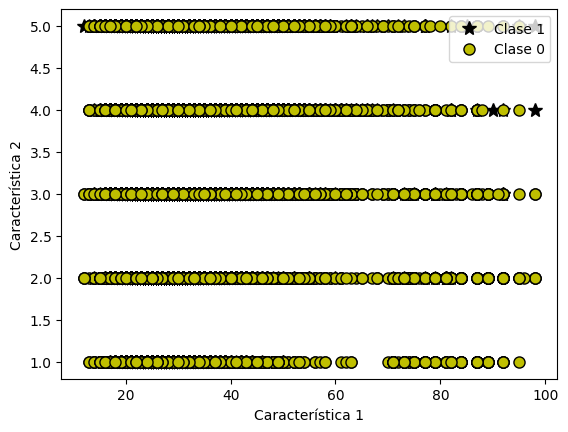

In [10]:
plotData(X_train, y_train)
# Adiciona etiquetas para los ejes
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend(['Clase 1', 'Clase 0'])
plt.show()

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [11]:
def sigmoid(z):
    # Calcula la sigmoide de una entrada z
    z = np.array(z)
    g = 1 / (1 + np.exp(-z))
    return g

Se calcula el valor de la sigmoide aplicando la funcion sigmoid con `z=0`, se debe obtener un resultado de 0.5. RE recomienda experimentar con otros valores de `z`.

In [12]:
# Prueba la implementación de la función sigmoid
z = [0, 0.5, 1]
g = sigmoid(z)
print('g(', z, ') = ', g)

g( [0, 0.5, 1] ) =  [0.5        0.62245933 0.73105858]


<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Se implementa la funcion cost y gradient, para la regresión logistica. Antes de continuar es importante agregar el termino de intercepcion a X.

In [13]:
# Configurar la matriz adecuadamente y agregar una columna de unos que corresponde al término de intercepción.
m, n = X_train.shape
# Agrega el término de intercepción a X_train
X_train = np.concatenate([np.ones((m, 1)), X_train], axis=1)

La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [14]:
def calcularCosto(theta, X, y):
    # Inicializa algunos valores útiles
    m = y.size  # Número de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [15]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0]  # Número de ejemplos de entrenamiento

    # Realiza una copia de theta, el cual será actualizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)
        J_history.append(calcularCosto(theta, X, y))

    return theta, J_history

Theta calculado por el descenso por el gradiente: [-0.0036882  -0.0723971  -0.0008557   0.00196298  0.02566578 -0.00927402
 -0.03034503]
Para un conjunto de características dado, la probabilidad predicha es: 0.00


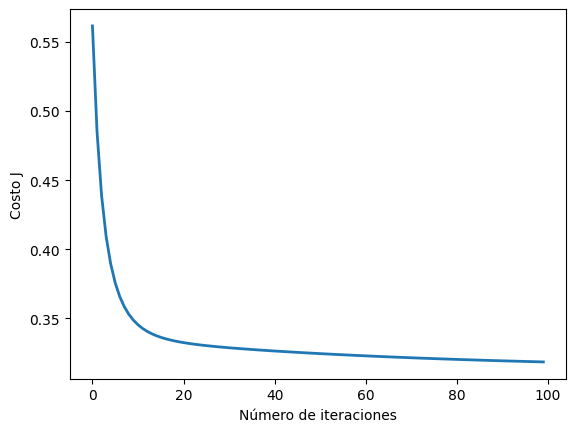

In [16]:
# Elegir algún valor para alpha (probar varias alternativas)
alpha = 0.001
num_iters = 100

# Inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(n + 1)
theta, J_history = descensoGradiente(theta, X_train, y_train, alpha, num_iters)

# Gráfica la convergencia del costo
plt.plot(np.arange(len(J_history)), J_history, lw=2)
plt.xlabel('Número de iteraciones')
plt.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('Theta calculado por el descenso por el gradiente:', theta)

# Verificar predicción para un conjunto específico
X_array = [1, 80, 46, 70, 60, 50, 85]  # Ajustar según características
aprueba = sigmoid(np.dot(X_array, theta))

print('Para un conjunto de características dado, la probabilidad predicha es: {:.2f}'.format(aprueba))

In [17]:
X_array = [1, 80, 50, 60, 70, 80, 90]  # Ajustar según características
y_predicted = sigmoid(np.dot(X_array, theta))
print('Para el conjunto de características dado, la probabilidad predicha es: {:.2f}'.format(y_predicted))

Para el conjunto de características dado, la probabilidad predicha es: 0.00


In [18]:
def costFunction(theta, X, y):
    # Inicializa algunos valores útiles
    m = y.size  # Número de ejemplos de entrenamiento

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)

    return J, grad

Se prueba la funcion `costFunction` utilizando dos casos de prueba para $\theta$.

In [19]:
# Inicialización de parámetros de ajuste
initial_theta = np.zeros(n + 1)
cost, grad = costFunction(initial_theta, X_train, y_train)

print('Costo en theta inicial (zeros): {:.3f}'.format(cost))
print('Gradiente en theta inicial (zeros):', grad)

Costo en theta inicial (zeros): 0.693
Gradiente en theta inicial (zeros): [ 0.4054098  11.40110532  0.93795583  1.1489617   1.25925205  3.05923776
  2.54001419]


In [20]:
# Calcula y muestra el costo y el gradiente con valores de theta diferentes a cero
test_theta = np.array([-24, 0.2, 0.2, 0.1, 0.3, 0.4, 0.5])  # Ajustar dimensiones si es necesario
cost, grad = costFunction(test_theta, X_train, y_train)

print('Costo en theta de prueba: {:.3f}'.format(cost))
print('Gradiente en theta de prueba:', grad)

Costo en theta de prueba: 0.773
Gradiente en theta de prueba: [-0.0658074  -1.72978066 -0.2005593  -0.01194694 -0.05307026 -0.69049167
 -0.33246881]


#### 1.2.3 Parámetros de aprendizaje usando `scipy.optimize`

En el codigo anterior se encontró los parámetros óptimos de un modelo de regresión lineal al implementar el descenso de gradiente. Se implemento una función de costo y se calculó su gradiente, utilizando el algoritmo del descenso por el gradiente.

En lugar de realizar los pasos del descenso por el gradiente, se utilizará el [módulo `scipy.optimize`] (https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una biblioteca de computación numérica para `python`. Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:

Para la regresión logística, se desea optimizar la función de costo $J(\theta)$ con los parámetros $\theta$.
Concretamente, se va a utilizar `optimize.minimize` para encontrar los mejores parámetros $\theta$ para la función de costo de regresión logística, dado un dataset fijo (de valores X e y). Se pasara a `optimize.minimize` las siguientes entradas:

- `costFunction`: Una función de costo que, cuando se le da el dataset de entrenamiento y un $\theta$ particular, calcula el costo de regresión logística y el gradiente con respecto a $\theta$ para el dataset(X, y). Es importante tener en cuenta que solo se pasa el nombre de la función sin el paréntesis. Esto indica que solo proporcionamos una referencia a esta función y no evaluamos el resultado de esta función.
- `initial_theta`: Los valores iniciales de los parametros que se tratan de optimizar.
- `(X, y)`: Estos son argumentos adicionales a la funcion de costo.
- `jac`: Indicación si la función de costo devuelve el jacobiano (gradiente) junto con el valor de costo. (True)
- `method`: Método / algoritmo de optimización a utilizar
- `options`: Opciones adicionales que pueden ser específicas del método de optimización específico. Solo se indica al algoritmo el número máximo de iteraciones antes de que termine.

Si se ha completado la `costFunction` correctamente,`optimize.minimize` convergerá en los parámetros de optimización correctos y devolverá los valores finales del costo y $\theta$ en un objeto de clase.

Al usar `optimize.minimize`, no se tuvo que escribir ningún bucle ni establecer una tasa de aprendizaje como se hizo para el descenso de gradientes. Todo esto se hace mediante `optimize.minimize`: solo se necesita proporcionar una función que calcule el costo y el gradiente.

A continuación, se tiene el código para llamar a `optimize.minimize` con los argumentos correctos.

In [21]:
# Establecer las opciones para optimize.minimize
options = {'maxiter': 1000}

# Revisar la documentación de scipy's optimize.minimize para mayor descripción de los parámetros
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X_train, y_train),
                        jac=True,
                        method='TNC',
                        options=options)

# La propiedad `fun` del objeto devuelto por `OptimizeResult` contiene el valor del costFunction de un theta optimizado
cost = res.fun

# Theta optimizada está en la propiedad `x`
theta = res.x

# Imprimir theta optimizada
print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))
print('Theta optimizada:', theta)

<ipython-input-21-23a2650de068>:5: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunction,


Costo con un valor de theta encontrado por optimize.minimize: 0.258
Theta optimizada: [-7.24504530e+00  1.65106640e-02  6.62394172e-01  4.42354966e-03
  4.93714565e-03  3.02202179e-01 -3.62999401e-02]


Una vez que se completa `optimize.minimize`, se usa el valor final de $\theta$ para visualizar el límite de decisión en los datos de entrenamiento.

Para hacerlo, se implementa la función `plotDecisionBoundary` para trazar el límite de decisión sobre los datos de entrenamiento.

In [22]:
def plotDecisionBoundary(plotData, theta, X, y):
    """
    Grafica los puntos X y Y en una nueva figura con un límite de decisión definido por theta.
    Grafica los puntos con * para los ejemplos positivos y con o para los ejemplos negativos.
    """
    # Hacer que theta sea un arreglo numpy
    theta = np.array(theta)

    # Graficar los datos (recordar que la primera columna en X es la intercepción)
    plotData(X[:, 1:3], y)  # Ajusta para graficar las dos primeras características

    if X.shape[1] <= 3:
        # Solo se requieren 2 puntos para definir una línea, para lo cual se eligen dos puntos finales
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

        # Calcular la línea límite de decisión
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        # Graficar y ajustar los ejes para una mejor visualización
        plt.plot(plot_x, plot_y, label='Límite de decisión')
        plt.xlim([np.min(X[:, 1]) - 5, np.max(X[:, 1]) + 5])
        plt.ylim([np.min(X[:, 2]) - 5, np.max(X[:, 2]) + 5])
        plt.legend()
        plt.show()

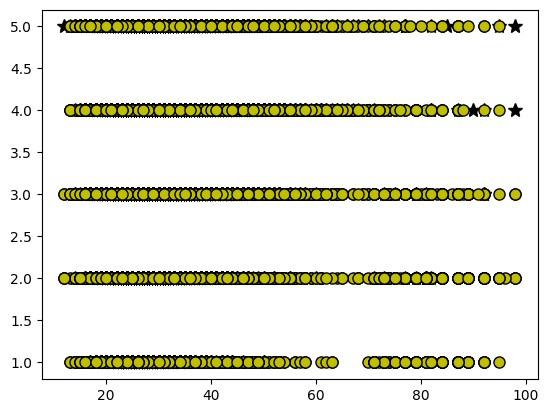

In [23]:
# Graficar límites de decisión
plotDecisionBoundary(plotData, theta, X_train, y_train)

<a id="section4"></a>
#### 1.2.4 Evaluación de la regresión logistica

Después de aprender los parámetros, se puede usar el modelo para predecir si un estudiante en particular será admitido. Para un estudiante con una puntuación en el Examen 1 de 45 y una puntuación en el Examen 2 de 85, debe esperar ver una probabilidad de admisión de 0,776. Otra forma de evaluar la calidad de los parámetros que hemos encontrado es ver qué tan bien predice el modelo aprendido en nuestro conjunto de entrenamiento.

In [24]:
def predict(theta, X):
    """
    Predecir si la etiqueta es 0 o 1 mediante regresión logística aprendida.
    Calcula las predicciones para X usando un umbral en 0.5 (es decir, si sigmoide (theta.T * x) >= 0.5, predice 1)

    Devuelve predicciones de 0 o 1 para cada fila en X.
    """
    m = X.shape[0]  # Número de ejemplos de entrenamiento
    p = np.zeros(m)
    p = np.round(sigmoid(X.dot(theta.T)))
    return p

Una vez entrenado el modelo se procede a realizar la prediccion y evaluación de los resultados de predecir cual es el valor que vota el modelo para todos los datos utilizados en el entrenamiento.

In [25]:
# Predecir la probabilidad de ingreso para un estudiante con valores específicos de las características
prob = sigmoid(np.dot([1, 45, 85, 70, 50, 60, 75], theta))  # Ajustar los valores según las características
print('Para un conjunto de características dado, se predice una probabilidad de: {:.3f}'.format(prob))

# Calcular la precisión en el conjunto de entrenamiento
p = predict(theta, X_train)
print('Precisión de entrenamiento: {:.2f} %'.format(np.mean(p == y_train) * 100))

# Calcular la precisión en el conjunto de prueba
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)  # Añadir columna de unos a X_test
p_test = predict(theta, X_test)
print('Precisión de prueba: {:.2f} %'.format(np.mean(p_test == y_test) * 100))

Para un conjunto de características dado, se predice una probabilidad de: 1.000
Precisión de entrenamiento: 90.48 %
Precisión de prueba: 90.70 %
